# Hızlı Model Değerlendirme ve Karşılaştırma

Bu notebook ile:
1. Mevcut modellerinizi test edeceksiniz
2. Performansı karşılaştıracaksınız
3. İyileştirmeleri göreceksiniz


In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model  # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences  # type: ignore
import sys
sys.path.append('..')
from utils import basic_clean

print("Kutuphaneler yuklendi!")


Kutuphaneler yuklendi!


## 1. Veriyi Hazırla


In [2]:
# Veriyi yükle
df = pd.read_csv("../data/cleaned_data.csv")

# Aynı şekilde böl
X_train, X_tmp, y_train, y_tmp = train_test_split(
    df["text"], df["label"], test_size=0.2, random_state=42, stratify=df["label"]
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, random_state=42, stratify=y_tmp
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
print(f"Test seti sinif dagilimi:\\n{y_test.value_counts()}")


Train: 38269, Val: 4784, Test: 4784
Test seti sinif dagilimi:\nlabel
Hardware                 1362
HR Support               1091
Access                    713
Miscellaneous             706
Storage                   277
Purchase                  247
Internal Project          212
Administrative rights     176
Name: count, dtype: int64


## 2. Baseline Model Değerlendir


In [3]:
# Baseline model yukle
with open("../models/baseline_tfidf_logreg.pkl", "rb") as f:
    baseline_model = pickle.load(f)

# Test et
baseline_pred = baseline_model.predict(X_test)
baseline_acc = accuracy_score(y_test, baseline_pred)

print("="*60)
print("BASELINE MODEL (TF-IDF + Logistic Regression)")
print("="*60)
print(f"Test Accuracy: {baseline_acc:.4f} ({baseline_acc*100:.2f}%)")
print("\\n" + classification_report(y_test, baseline_pred, zero_division=0))


BASELINE MODEL (TF-IDF + Logistic Regression)
Test Accuracy: 0.8604 (86.04%)
\n                       precision    recall  f1-score   support

               Access       0.92      0.86      0.89       713
Administrative rights       0.90      0.61      0.73       176
           HR Support       0.87      0.88      0.87      1091
             Hardware       0.79      0.91      0.85      1362
     Internal Project       0.93      0.78      0.85       212
        Miscellaneous       0.84      0.83      0.83       706
             Purchase       0.99      0.88      0.93       247
              Storage       0.97      0.82      0.89       277

             accuracy                           0.86      4784
            macro avg       0.90      0.82      0.85      4784
         weighted avg       0.87      0.86      0.86      4784



## 3. LSTM Model Değerlendir


In [4]:
# LSTM model yukle
lstm_model = load_model("../models/word2vec_lstm_model.h5")

with open("../models/tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)
    
with open("../models/label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

# Preprocess
X_test_clean = X_test.apply(basic_clean)
sequences = tokenizer.texts_to_sequences(X_test_clean)
padded = pad_sequences(sequences, maxlen=80, padding="post", truncating="post")

# Predict
lstm_probs = lstm_model.predict(padded)
lstm_pred_idx = lstm_probs.argmax(axis=1)
lstm_pred = label_encoder.inverse_transform(lstm_pred_idx)

# Accuracy
y_test_encoded = label_encoder.transform(y_test)
lstm_acc = accuracy_score(y_test_encoded, lstm_pred_idx)

print("="*60)
print("LSTM MODEL (Word2Vec + Bidirectional LSTM)")
print("="*60)
print(f"Test Accuracy: {lstm_acc:.4f} ({lstm_acc*100:.2f}%)")
print("\\n" + classification_report(y_test, lstm_pred, zero_division=0))


150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step
LSTM MODEL (Word2Vec + Bidirectional LSTM)
Test Accuracy: 0.8700 (87.00%)
\n                       precision    recall  f1-score   support

               Access       0.89      0.92      0.90       713
Administrative rights       0.78      0.89      0.83       176
           HR Support       0.88      0.90      0.89      1091
             Hardware       0.91      0.79      0.85      1362
     Internal Project       0.82      0.90      0.86       212
        Miscellaneous       0.80      0.87      0.83       706
             Purchase       0.89      0.94      0.91       247
              Storage       0.93      0.90      0.91       277

             accuracy                           0.87      4784
            macro avg       0.86      0.89      0.87      4784
         weighted avg       0.87      0.87      0.87      4784



## 4. Model Karşılaştırması


MODEL KARSILASTIRMASI
Baseline (TF-IDF + LogReg): 0.8604 (86.04%)
LSTM (Word2Vec + BiLSTM):   0.8700 (87.00%)
Iyilestirme:                 +0.96%


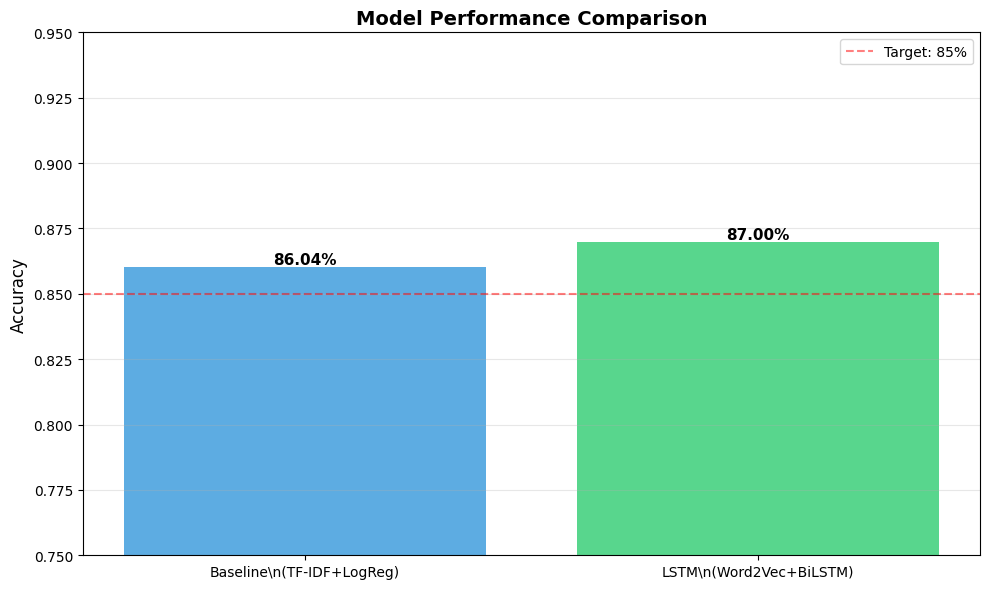

\nGrafik kaydedildi: reports/model_comparison.png


In [5]:
print("="*60)
print("MODEL KARSILASTIRMASI")
print("="*60)
print(f"Baseline (TF-IDF + LogReg): {baseline_acc:.4f} ({baseline_acc*100:.2f}%)")
print(f"LSTM (Word2Vec + BiLSTM):   {lstm_acc:.4f} ({lstm_acc*100:.2f}%)")
print(f"Iyilestirme:                 +{(lstm_acc-baseline_acc)*100:.2f}%")
print("="*60)

# Bar chart
models = ['Baseline\\n(TF-IDF+LogReg)', 'LSTM\\n(Word2Vec+BiLSTM)']
accuracies = [baseline_acc, lstm_acc]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=['#3498db', '#2ecc71'], alpha=0.8)
plt.ylim([0.75, 0.95])
plt.ylabel('Accuracy', fontsize=12)
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.axhline(y=0.85, color='r', linestyle='--', label='Target: 85%', alpha=0.5)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc*100:.2f}%',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('../reports/model_comparison.png', dpi=300)
plt.show()

print("\\nGrafik kaydedildi: reports/model_comparison.png")


## 5. En İyi ve En Kötü Sınıflar


In [6]:
from sklearn.metrics import precision_recall_fscore_support

# LSTM için sınıf bazında metrikler
precision, recall, f1, support = precision_recall_fscore_support(
    y_test, lstm_pred, average=None, zero_division=0
)

classes = sorted(df['label'].unique())
class_metrics = pd.DataFrame({
    'Class': classes,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
}).sort_values('F1-Score', ascending=False)

print("\\n" + "="*60)
print("SINIF BAZINDA PERFORMANS (LSTM)")
print("="*60)
print(class_metrics.to_string(index=False))

print("\\n En İyi 3 Sınıf (F1-Score):")
print(class_metrics.head(3)[['Class', 'F1-Score']].to_string(index=False))

print("\\n En Düşük 3 Sınıf (F1-Score):")
print(class_metrics.tail(3)[['Class', 'F1-Score']].to_string(index=False))


\n============================================================
SINIF BAZINDA PERFORMANS (LSTM)
                Class  Precision   Recall  F1-Score  Support
              Storage   0.925926 0.902527  0.914077      277
             Purchase   0.891892 0.935223  0.913043      247
               Access   0.885135 0.918654  0.901583      713
           HR Support   0.877788 0.901925  0.889693     1091
     Internal Project   0.816239 0.900943  0.856502      212
             Hardware   0.910624 0.792952  0.847724     1362
        Miscellaneous   0.795337 0.869688  0.830853      706
Administrative rights   0.777228 0.892045  0.830688      176
\n En İyi 3 Sınıf (F1-Score):
   Class  F1-Score
 Storage  0.914077
Purchase  0.913043
  Access  0.901583
\n En Düşük 3 Sınıf (F1-Score):
                Class  F1-Score
             Hardware  0.847724
        Miscellaneous  0.830853
Administrative rights  0.830688


## 6. Sonuç ve Öneriler


In [7]:
print("\\n" + "="*60)
print("SONUC ve IYILESTIRME ONERILERI")
print("="*60)

print(f"\\nMevcut En İyi Model: LSTM ({lstm_acc*100:.2f}%)")
print(f"\\nIyilestirme Potansiyeli:")
print(f"  - BERT Fine-tuning: +3-6% → Hedef: 90-93%")
print(f"  - Hyperparameter Tuning: +1-2% → Hedef: 88-89%")
print(f"  - Ensemble (Baseline+LSTM): +2-3% → Hedef: 89-90%")
print(f"  - Ensemble (All models): +4-7% → Hedef: 91-94%")

print(f"\\nOncelikli Adimlar:")
print(f"  1. BERT modelini egit (en yuksek kazanc)")
print(f"  2. Ensemble yap (hizli kazanc)")
print(f"  3. Hyperparameter tuning (kolay kazanc)")

print("\\n" + "="*60)
print("DEGER LENDIRME TAMAMLANDI!")
print("="*60)


\n============================================================
SONUC ve IYILESTIRME ONERILERI
\nMevcut En İyi Model: LSTM (87.00%)
\nIyilestirme Potansiyeli:
  - BERT Fine-tuning: +3-6% → Hedef: 90-93%
  - Hyperparameter Tuning: +1-2% → Hedef: 88-89%
  - Ensemble (Baseline+LSTM): +2-3% → Hedef: 89-90%
  - Ensemble (All models): +4-7% → Hedef: 91-94%
\nOncelikli Adimlar:
  1. BERT modelini egit (en yuksek kazanc)
  2. Ensemble yap (hizli kazanc)
  3. Hyperparameter tuning (kolay kazanc)
\n============================================================
DEGER LENDIRME TAMAMLANDI!
